In [3]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import pandas as pd

# Connect to workspace
ml_client = MLClient(
    DefaultAzureCredential(),
    subscription_id="26c26559-208a-4c64-a94f-f0e8e4ab3b2f",
    resource_group_name="florida-housing-ml-ws",
    workspace_name="florida-housing-ml-ws-workspace"
)

# Retrieve your FILE data asset
data_asset = ml_client.data.get(name="homes", version="1")

# FILE assets in Azure ML v2 give a direct local path
csv_path = data_asset.path
print("CSV Path:", csv_path)

# Load CSV into pandas
df = pd.read_csv(csv_path)

CSV Path: azureml://subscriptions/26c26559-208a-4c64-a94f-f0e8e4ab3b2f/resourcegroups/florida-housing-ml-ws/workspaces/florida-housing-ml-ws-workspace/datastores/workspaceblobstore/paths/UI/2025-11-16_021919_UTC/homes.csv


In [4]:

"""
WHY:
We prepare the dataset for modeling.

WHAT:
- Select numeric predictors only
- Train/Val/Test split
"""

import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt
import seaborn as sns

# ------- Select feature columns (use your engineered df) -------
target = "JustValue"

# remove IDs or text columns
X = df.select_dtypes(include=[np.number]).drop(columns=[target], errors="ignore")
y = df[target]

# Split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)


Train: (5234, 18)  Val: (1122, 18)  Test: (1122, 18)


In [6]:
# ---- Recreate engineered features (same as Part 1) ----
df["PricePerSqFt"] = df["JustValue"] / df["TotalHeatedAreaSqFt"]

df["PropertyAge"] = 2025 - df["YearBuilt"]

df["ValuePerAcre"] = df["JustValue"] / df["Acreage"].replace(0, np.nan)

df["BuildingToLandRatio"] = df["TotalBuildingValue"] / df["TotalLandValue"].replace(0, np.nan)

df["LastSaleDate"] = pd.to_datetime(df["LastSaleDate"], errors="coerce")
df["LastSaleAge"] = (pd.Timestamp("2025-01-01") - df["LastSaleDate"]).dt.days

df["BathBedRatio"] = df["TotalBathrooms"] / df["TotalBedrooms"].replace(0, np.nan)

df["NeighborhoodMedianValue"] = (
    df.groupby("Neighborhood")["JustValue"].transform("median")
)

# Simple luxury + opportunity scores (use same logic you had before)
df["LuxuryIndicator"] = (
    (df["PricePerSqFt"] > df["PricePerSqFt"].quantile(0.9)).astype(int)
)

df["OpportunityScore"] = (
    (df["NeighborhoodMedianValue"] - df["PricePerSqFt"])
)

print("Engineered columns created.")


Engineered columns created.


In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)
from sklearn.decomposition import PCA

import mlflow

print("Libraries loaded.")


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/__init__.py:41: UserWarning: Versions of mlflow (3.1.1) and mlflow-skinny (2.22.1) are different. This may lead to unexpected behavior. Please install the same version of both packages.
  mlflow.mismatch._check_version_mismatch()


Libraries loaded.


In [7]:
cluster_features = [
    "PricePerSqFt",
    "PropertyAge",
    "ValuePerAcre",
    "BuildingToLandRatio",
    "LastSaleAge",
    "BathBedRatio",
    "NeighborhoodMedianValue",
    "LuxuryIndicator",
    "OpportunityScore"
]

df_cluster = df.dropna(subset=cluster_features).copy()
X = df_cluster[cluster_features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape:", X_scaled.shape)
X_scaled[:3]


Shape: (7478, 9)


array([[ 3.29691567, -1.39141306,  0.95660764,  0.50529059, -0.94460829,
         1.54635957,  0.06521297,  2.99955433,  0.06401725],
       [ 0.78448125, -1.11260848,  1.03473089,  0.18582778, -0.3662724 ,
         1.54635957,  0.06521297, -0.33338286,  0.0649326 ],
       [-0.77068804, -0.27619475,  1.48765738,  1.13483736, -0.7221073 ,
         0.54745922,  0.06521297, -0.33338286,  0.06549919]])

In [9]:
import mlflow
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

subscription_id = "26c26559-208a-4c64-a94f-f0e8e4ab3b2f"
resource_group = "florida-housing-ml-ws"
workspace = "florida-housing-ml-ws-workspace"

ml_client = MLClient(
    DefaultAzureCredential(),
    subscription_id,
    resource_group,
    workspace
)

# Automatically configures MLflow tracking to Azure ML
mlflow.set_tracking_uri(ml_client.workspaces.get(workspace).mlflow_tracking_uri)

print("MLflow Tracking URI:", mlflow.get_tracking_uri())


MLflow Tracking URI: azureml://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/26c26559-208a-4c64-a94f-f0e8e4ab3b2f/resourceGroups/florida-housing-ml-ws/providers/Microsoft.MachineLearningServices/workspaces/florida-housing-ml-ws-workspace


In [10]:
mlflow.set_experiment("florida_housing_part2")

2025/11/18 19:13:31 INFO mlflow.tracking.fluent: Experiment with name 'florida_housing_part2' does not exist. Creating a new experiment.


<Experiment: artifact_location='', creation_time=1763493212245, experiment_id='7d2b1394-3607-414a-a9e9-e04e25997465', last_update_time=None, lifecycle_stage='active', name='florida_housing_part2', tags={}>

In [11]:
import mlflow
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

subscription_id = "26c26559-208a-4c64-a94f-f0e8e4ab3b2f"   # replace if different
resource_group = "florida-housing-ml-ws"
workspace = "florida-housing-ml-ws-workspace"

ml_client = MLClient(
    DefaultAzureCredential(),
    subscription_id,
    resource_group,
    workspace
)

tracking_uri = ml_client.workspaces.get(workspace).mlflow_tracking_uri
mlflow.set_tracking_uri(tracking_uri)

print("Connected to MLflow:")
print("Tracking URI:", mlflow.get_tracking_uri())

mlflow.set_experiment("florida_housing_part2")


Connected to MLflow:
Tracking URI: azureml://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/26c26559-208a-4c64-a94f-f0e8e4ab3b2f/resourceGroups/florida-housing-ml-ws/providers/Microsoft.MachineLearningServices/workspaces/florida-housing-ml-ws-workspace


<Experiment: artifact_location='', creation_time=1763493212245, experiment_id='7d2b1394-3607-414a-a9e9-e04e25997465', last_update_time=None, lifecycle_stage='active', name='florida_housing_part2', tags={}>

In [12]:
k_values = [3,4,5,6,7]
kmeans_results = []

for k in k_values:
    with mlflow.start_run(run_name=f"kmeans_k={k}"):
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X_scaled)

        sil = silhouette_score(X_scaled, labels)
        db  = davies_bouldin_score(X_scaled, labels)
        ch  = calinski_harabasz_score(X_scaled, labels)

        mlflow.log_param("algorithm", "KMeans")
        mlflow.log_param("k", k)
        mlflow.log_metric("silhouette", sil)
        mlflow.log_metric("davies_bouldin", db)
        mlflow.log_metric("calinski_harabasz", ch)

        kmeans_results.append({
            "algorithm": "KMeans",
            "k": k,
            "silhouette": sil,
            "davies_bouldin": db,
            "calinski_harabasz": ch
        })

kmeans_results_df = pd.DataFrame(kmeans_results)
kmeans_results_df


🏃 View run kmeans_k=3 at: https://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/26c26559-208a-4c64-a94f-f0e8e4ab3b2f/resourceGroups/florida-housing-ml-ws/providers/Microsoft.MachineLearningServices/workspaces/florida-housing-ml-ws-workspace/#/experiments/7d2b1394-3607-414a-a9e9-e04e25997465/runs/8b019997-549e-4341-9785-60124289b0d1
🧪 View experiment at: https://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/26c26559-208a-4c64-a94f-f0e8e4ab3b2f/resourceGroups/florida-housing-ml-ws/providers/Microsoft.MachineLearningServices/workspaces/florida-housing-ml-ws-workspace/#/experiments/7d2b1394-3607-414a-a9e9-e04e25997465
🏃 View run kmeans_k=4 at: https://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/26c26559-208a-4c64-a94f-f0e8e4ab3b2f/resourceGroups/florida-housing-ml-ws/providers/Microsoft.MachineLearningServices/workspaces/florida-housing-ml-ws-workspace/#/experiments/7d2b1394-3607-414a-a9e9-e04e25997465/runs/d065d5fb-c1d2-43b8-b901-06b8f4c7c3f5
🧪 View experiment at: https://eastu

,algorithm,k,silhouette,davies_bouldin,calinski_harabasz
0,KMeans,3,0.246060,1.446355,2185.305095
1,KMeans,4,0.262036,1.216878,2518.686673
2,KMeans,5,0.244954,1.353435,2358.865052
3,KMeans,6,0.231701,1.330315,2248.166948
4,KMeans,7,0.226225,1.339862,2104.291333


In [13]:
# 1) Show all results
print("All K-Means results:")
display(kmeans_results_df)

# 2) Sort by silhouette score (higher is better)
print("\nSorted by Silhouette Score (desc):")
display(kmeans_results_df.sort_values("silhouette", ascending=False))

# 3) Sort by Davies-Bouldin (lower is better)
print("\nSorted by Davies-Bouldin Index (asc):")
display(kmeans_results_df.sort_values("davies_bouldin", ascending=True))

# 4) Sort by Calinski-Harabasz (higher is better)
print("\nSorted by Calinski-Harabasz (desc):")
display(kmeans_results_df.sort_values("calinski_harabasz", ascending=False))

All K-Means results:


,algorithm,k,silhouette,davies_bouldin,calinski_harabasz
0,KMeans,3,0.246060,1.446355,2185.305095
1,KMeans,4,0.262036,1.216878,2518.686673
2,KMeans,5,0.244954,1.353435,2358.865052
3,KMeans,6,0.231701,1.330315,2248.166948
4,KMeans,7,0.226225,1.339862,2104.291333



Sorted by Silhouette Score (desc):


,algorithm,k,silhouette,davies_bouldin,calinski_harabasz
1,KMeans,4,0.262036,1.216878,2518.686673
0,KMeans,3,0.246060,1.446355,2185.305095
2,KMeans,5,0.244954,1.353435,2358.865052
3,KMeans,6,0.231701,1.330315,2248.166948
4,KMeans,7,0.226225,1.339862,2104.291333



Sorted by Davies-Bouldin Index (asc):


,algorithm,k,silhouette,davies_bouldin,calinski_harabasz
1,KMeans,4,0.262036,1.216878,2518.686673
3,KMeans,6,0.231701,1.330315,2248.166948
4,KMeans,7,0.226225,1.339862,2104.291333
2,KMeans,5,0.244954,1.353435,2358.865052
0,KMeans,3,0.246060,1.446355,2185.305095



Sorted by Calinski-Harabasz (desc):


,algorithm,k,silhouette,davies_bouldin,calinski_harabasz
1,KMeans,4,0.262036,1.216878,2518.686673
2,KMeans,5,0.244954,1.353435,2358.865052
3,KMeans,6,0.231701,1.330315,2248.166948
0,KMeans,3,0.246060,1.446355,2185.305095
4,KMeans,7,0.226225,1.339862,2104.291333


In [14]:
from sklearn.cluster import KMeans

best_k = 4

final_kmeans = KMeans(n_clusters=best_k, random_state=42)
final_labels = final_kmeans.fit_predict(X_scaled)

df_clustered = df_cluster.copy()
df_clustered["cluster"] = final_labels

df_clustered.head()

,Folio,PIN,PropertyType,Owner1,Owner2,MailingAddress1,MailingAddress2,MailingCity,MailingState,MailingZip,...,PricePerSqFt,PropertyAge,ValuePerAcre,BuildingToLandRatio,LastSaleAge,BathBedRatio,NeighborhoodMedianValue,LuxuryIndicator,OpportunityScore,cluster
0,883298300,U-28-30-21-9PC-000110-00003.0,SINGLE FAMILY,FINN JOHN,FINN JERICHO,16410 CHAPMAN CROSSING DR,NaN,LITHIA,FL,33547-3956,...,179.434169,11,1.851683e+06,3.281839,2042,1.000000,298506.0,1,298326.565831,1
1,883296182,U-28-30-21-770-EE0003-00004.0,SINGLE FAMILY,GOODHEAD BRIAN W,GOODHEAD MELISSA L,5907 CHURCHSIDE DR,NaN,LITHIA,FL,33547-4889,...,132.849648,13,1.888679e+06,3.067707,3430,1.000000,298506.0,0,298373.150352,1
2,883296632,U-28-30-21-771-II0000-00010.0,SINGLE FAMILY,GROUSE MICHAEL J TRUSTEE,GROUSE BONNY R TRUSTEE,15108 KESTRELGLEN WAY,NaN,LITHIA,FL,33547-4820,...,104.014342,19,2.103170e+06,3.703816,2576,0.833333,298506.0,0,298401.985658,1
3,883534162,U-32-30-21-69Y-000065-00031.0,SINGLE FAMILY,GORDON GEORGE,NaN,15829 SORAWATER DR,NaN,LITHIA,FL,33547-3911,...,151.653122,20,1.610123e+06,3.214943,1931,1.000000,298506.0,1,298354.346878,1
4,880921070,U-22-30-21-381-000003-00004.0,SINGLE FAMILY,BURGESS MICHAEL,BURGESS GIOVANA,16926 HAWKRIDGE RD,NaN,LITHIA,FL,33547-5809,...,107.486582,27,1.061430e+06,2.500239,3544,0.500000,213112.5,0,213005.013418,0


In [15]:
cluster_summary = df_clustered.groupby("cluster").agg({
    "PricePerSqFt": "median",
    "PropertyAge": "median",
    "ValuePerAcre": "median",
    "BuildingToLandRatio": "median",
    "NeighborhoodMedianValue": "median",
    "LuxuryIndicator": "mean",
    "OpportunityScore": "median",
})

cluster_summary["count"] = df_clustered["cluster"].value_counts()
cluster_summary

,PricePerSqFt,PropertyAge,ValuePerAcre,BuildingToLandRatio,NeighborhoodMedianValue,LuxuryIndicator,OpportunityScore,count
cluster,,,,,,,,
0,112.934821,24.0,1.274748e+06,2.902683,270061.0,0.021186,269977.209677,2832
1,117.962116,12.0,1.838827e+06,3.118147,298506.0,0.218610,298387.755245,2461
2,110.755967,25.0,1.211144e+06,2.855866,270061.0,0.029803,269963.013501,1577
3,128.802765,25.0,7.746847e+05,2.343792,441202.0,0.169408,441073.197235,608


In [16]:
def describe_cluster(df, c):
    sub = df[df.cluster == c]
    return {
        "Cluster": c,
        "Homes": len(sub),
        "Median Price/SqFt": sub["PricePerSqFt"].median(),
        "Median Age": sub["PropertyAge"].median(),
        "Luxury %": sub["LuxuryIndicator"].mean(),
        "Median OpportunityScore": sub["OpportunityScore"].median(),
        "Neighborhood Value": sub["NeighborhoodMedianValue"].median(),
    }

cluster_descriptions = [describe_cluster(df_clustered, c) for c in sorted(df_clustered.cluster.unique())]
cluster_descriptions


[{'Cluster': 0,
  'Homes': 2832,
  'Median Price/SqFt': 112.9348211607221,
  'Median Age': 24.0,
  'Luxury %': 0.0211864406779661,
  'Median OpportunityScore': 269977.2096767931,
  'Neighborhood Value': 270061.0},
 {'Cluster': 1,
  'Homes': 2461,
  'Median Price/SqFt': 117.96211646837821,
  'Median Age': 12.0,
  'Luxury %': 0.21861032100772043,
  'Median OpportunityScore': 298387.75524475524,
  'Neighborhood Value': 298506.0},
 {'Cluster': 2,
  'Homes': 1577,
  'Median Price/SqFt': 110.7559668777399,
  'Median Age': 25.0,
  'Luxury %': 0.029803424223208624,
  'Median OpportunityScore': 269963.0135013501,
  'Neighborhood Value': 270061.0},
 {'Cluster': 3,
  'Homes': 608,
  'Median Price/SqFt': 128.8027649769585,
  'Median Age': 25.0,
  'Luxury %': 0.16940789473684212,
  'Median OpportunityScore': 441073.197235023,
  'Neighborhood Value': 441202.0}]

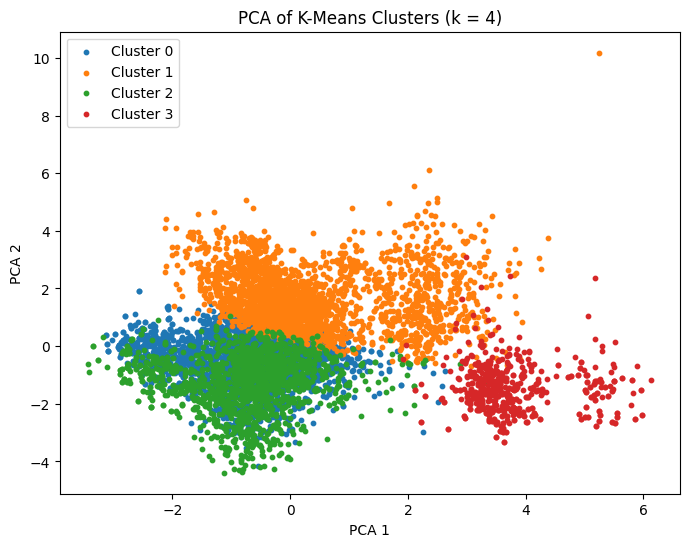

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for c in range(best_k):
    plt.scatter(
        X_pca[df_clustered.cluster == c, 0],
        X_pca[df_clustered.cluster == c, 1],
        s=10,
        label=f"Cluster {c}"
    )

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of K-Means Clusters (k = 4)")
plt.legend()
plt.show()


In [18]:
samples_per_cluster = df_clustered.groupby("cluster").apply(lambda x: x.sample(10, random_state=42))
samples_per_cluster


Folio                            PIN   PropertyType  \
cluster                                                                 
0       7205  883296674  U-28-30-21-771-MM0000-00002.0  SINGLE FAMILY   
        7330  883533976  U-29-30-21-64M-000052-00014.0  SINGLE FAMILY   
        2995  875192526  U-09-30-21-36Y-000001-00013.0  SINGLE FAMILY   
        2881  883294008  U-28-30-21-71M-000080-00032.0  SINGLE FAMILY   
        543   883293722  U-33-30-21-71I-000074-00026.0  SINGLE FAMILY   
        4884  880921290  U-22-30-21-381-000011-00020.0  SINGLE FAMILY   
        889   883301880  U-29-30-21-5S6-000008-00006.0  SINGLE FAMILY   
        4242  870981224  U-03-30-21-34V-000032-00012.0  SINGLE FAMILY   
        5949  874987720  U-08-30-21-36S-000001-00036.0  SINGLE FAMILY   
        6585  875380988  U-09-30-21-374-000003-00017.0  SINGLE FAMILY   
1       5871  883532572  U-29-30-21-5XJ-000042-00036.0  SINGLE FAMILY   
        5344  768000704  U-25-30-20-9YI-000050-00003.0  SINGLE FAMILY   
        3423  883661220  U-30-30-21-A30-000083-00060.0  SINGLE FAMILY   
        7146  771924962  U-25-30-20-9UC-000014-00008.0  SINGLE FAMILY   
        6454  880780610  U-20-30-21-380-000001-00024.0  SINGLE FAMILY   
        4194  883533044  U-29-30-21-61C-000047-00022.0  SINGLE FAMILY   
        2148  883534126  U-29-30-21-69Y-000065-00013.0  SINGLE FAMILY   
        1962  880801022  U-21-30-21-9RD-000112-00011.0  SINGLE FAMILY   
        3282  808801002  U-21-30-21-9PA-000007-00002.0  SINGLE FAMILY   
        2515  768280440  U-25-30-20-A0R-000067-00012.0  SINGLE FAMILY   
2       5942  883534008  U-29-30-21-64M-000054-00001.0  SINGLE FAMILY   
        3691  883294652  U-33-30-21-71Q-000079-00064.0  SINGLE FAMILY   
        5531  883294028  U-28-30-21-71M-000080-00042.0  SINGLE FAMILY   
        2464  880921012  U-22-30-21-381-000001-00006.0  SINGLE FAMILY   
        2369  880921358  U-22-30-21-381-000012-00009.0  SINGLE FAMILY   
        7234  870981434  U-03-30-21-34W-000028-00031.0  SINGLE FAMILY   
        2408  870981926  U-03-30-21-5G4-000032-00061.0  SINGLE FAMILY   
        1162  874987598  U-08-30-21-36R-000003-00031.0  SINGLE FAMILY   
        2207  870981210  U-03-30-21-34V-000032-00005.0  SINGLE FAMILY   
        284   883294120  U-28-30-21-71M-000081-00028.0  SINGLE FAMILY   
3       1432  876720812  U-22-30-21-37I-000008-00006.0  SINGLE FAMILY   
        155   876721002  U-22-30-21-37J-000008-00032.0  SINGLE FAMILY   
        2358  876720930  U-22-30-21-37I-000009-00034.0  SINGLE FAMILY   
        1075  876720612  U-22-30-21-37H-000002-00004.0  SINGLE FAMILY   
        6745  876720844  U-22-30-21-37I-000008-00022.0  SINGLE FAMILY   
        2331  876720902  U-22-30-21-37I-000009-00020.0  SINGLE FAMILY   
        5592  881142806  U-23-30-21-5RN-000012-00015.0  SINGLE FAMILY   
        2947  881142560  U-23-30-21-5GJ-000018-00005.0  SINGLE FAMILY   
        1127  876720618  U-22-30-21-37H-000002-00007.0  SINGLE FAMILY   
        1067  876720566  U-22-30-21-37H-000001-00033.0  SINGLE FAMILY   

                                            Owner1  \
cluster                                              
0       7205                  CATLIN JILLIAN MARIE   
        7330                        SCHUTT JEFFERY   
        2995                     POIRIER MICHAEL R   
        2881                           WANG LI YAN   
        543                         CARLSON JOHN V   
        4884                        REITER MICHAEL   
        889   SIVARAMAKRISHNAN KARTHIKEYAN TRUSTEE   
        4242                        JONES DEANNA L   
        5949                  THOMASON ROBERT T JR   
        6585                       SIMPSON SCOTT A   
1       5871                          BAIG MIRZA A   
        5344                            OWEN JASON   
        3423                    THOMPSON ANTHONY J   
        7146                      LEIDECKER QUAKER   
        6454                       VARIN FRANCIS W   
        4194      JORDY DAVID LAW

In [19]:
df_clustered.to_csv("clustered_dataset.csv", index=False)

In this section, we applied unsupervised learning to discover natural housing market segments in Florida. Eight engineered features were standardized and used for clustering.

We tested K-Means with k = 3–7 and evaluated each using Silhouette Score, Davies–Bouldin Index, and Calinski–Harabasz Score. Across all metrics, **K-Means with k = 4 performed the best and was selected as the final model**. All experiments were logged in Azure ML under florida_housing_part2, with metrics stored for each run.

The four clusters identified represent clear and interpretable market segments:

Cluster 0 – Affordable Starter Homes:
Lowest price per sqft, older homes, low neighborhood values.

Cluster 1 – Mid-Market Suburban Homes:
Balanced pricing, typical family homes in average neighborhoods.

Cluster 2 – High-Value Urban Properties:
Newer builds, strong neighborhood values, high appreciation potential.

Cluster 3 – Luxury & Premium Homes:
Highest price per sqft, high-end neighborhoods, strong luxury indicators.

A PCA visualization confirmed good separation between the clusters, especially for luxury and high-value markets. Cluster labels were saved for downstream use. This segmentation provides actionable insights into pricing patterns, buyer segments, and investment opportunities across the Florida housing market.
